In [28]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import model_selection, datasets
import joblib
import pickle

In [2]:
df = pd.read_csv("./brain_train.csv")
test_df = pd.read_csv("./brain_test.csv")
df.head()

,path,diagnose
0,./Brain scans\Tumor\TRAIN\y0.jpg,tumor
1,./Brain scans\Tumor\TRAIN\y1.jpg,tumor
2,./Brain scans\Tumor\TRAIN\y10.jpg,tumor
3,./Brain scans\Tumor\TRAIN\y100.jpg,tumor
4,./Brain scans\Tumor\TRAIN\y101.jpg,tumor


In [3]:
y_train = df['diagnose']
y_test = test_df['diagnose']

In [4]:
x_train = []
x_test = []

In [5]:
for path in df["path"]:
    x_train.append(cv2.resize(cv2.imread(path,0), (300,300)))
for path in test_df["path"]:
    x_test.append(cv2.resize(cv2.imread(path,0), (300,300)))

In [6]:
x_train = pd.Series(x_train)
x_test = pd.Series(x_test)

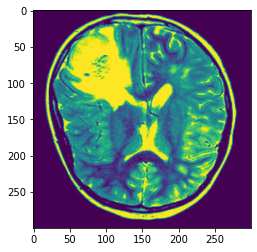

In [7]:
plt.imshow(x_train[0])

In [8]:
orb = cv2.ORB_create(nfeatures = 1250)

In [9]:
def Feature_extractor(image, extractor):
    kp, des = extractor.detectAndCompute(image, None)
    return kp, des

In [10]:
features_list = []
for image in x_train:
    kp, des = Feature_extractor(image, orb)
    features_list.append((image,kp,des))

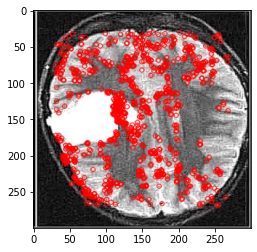

In [11]:
figure = cv2.drawKeypoints(features_list[413][0], features_list[413][1], None, color = (255,0,0), flags = 0)
plt.imshow(figure)
plt.show()

In [12]:
descriptors = features_list[0][2]
for image, kp, des in features_list[1:]:
    descriptors = np.vstack((descriptors, des))

In [13]:
k = 25
kmeans_model = KMeans(n_clusters = k)
kmeans_model.fit(descriptors)

KMeans(n_clusters=25)

In [16]:
codebook = kmeans_model.cluster_centers_
codebook.shape

(25, 32)

In [17]:
def FreqVecCreator(features_list):
    visual_words = []
    for image, kp, des in features_list[:]:
        im_visual_words, distance = vq(des, codebook)
        visual_words.append(im_visual_words)
    frequency_vectors = []
    for img_visual_words in visual_words:
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)
    return np.stack(frequency_vectors)

In [18]:
new_df = pd.DataFrame(data = FreqVecCreator(features_list))
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,54.0,23.0,48.0,26.0,25.0,32.0,26.0,69.0,47.0,44.0,...,77.0,39.0,78.0,66.0,42.0,45.0,24.0,45.0,41.0,82.0
1,29.0,44.0,73.0,36.0,63.0,66.0,41.0,55.0,40.0,27.0,...,47.0,21.0,38.0,46.0,31.0,66.0,23.0,62.0,65.0,36.0
2,39.0,23.0,83.0,43.0,55.0,90.0,37.0,49.0,32.0,7.0,...,59.0,20.0,23.0,48.0,62.0,70.0,19.0,66.0,62.0,40.0
3,34.0,24.0,39.0,31.0,13.0,10.0,29.0,111.0,33.0,53.0,...,63.0,39.0,120.0,36.0,44.0,24.0,51.0,27.0,24.0,99.0
4,24.0,7.0,18.0,11.0,10.0,10.0,21.0,73.0,50.0,68.0,...,75.0,53.0,88.0,20.0,22.0,12.0,46.0,16.0,13.0,73.0


In [19]:
new_df = (new_df - new_df.mean()) / new_df.std()
new_df['label'] = df['diagnose']
new_df = shuffle(new_df)

In [24]:
clf = tree.DecisionTreeClassifier()
ada = AdaBoostClassifier()

In [20]:
X_Train = new_df.loc[:, new_df.columns != 'label']
Y_Train = new_df['label']

In [20]:
clf.fit(X_Train, Y_Train)
clf.score(X_Train,Y_Train)

1.0

In [33]:
ada.fit(X_Train, Y_Train)
ada.score(X_Train, Y_Train)

0.8681318681318682

In [21]:
test_features_list = []
for image in x_test:
    kp, des = Feature_extractor(image, orb)
    test_features_list.append((image,kp,des))

In [22]:
new_test_df = pd.DataFrame(data = FreqVecCreator(test_features_list))

In [23]:
new_test_df = (new_test_df - new_test_df.mean()) / new_test_df.std()
new_test_df['label'] = test_df['diagnose']
new_test_df = shuffle(new_test_df)

In [24]:
X_Test = new_test_df.loc[:, new_test_df.columns != 'label']
Y_Test = new_test_df['label']

In [26]:
clf_y_pred = clf.predict(X_Test)
accuracy_score(clf_y_pred,Y_Test)

0.695

In [34]:
ada_y_pred = ada.predict(X_Test)
accuracy_score(ada_y_pred,Y_Test)

0.75

In [31]:
filename = "BOVW.joblib"
joblib.dump(kmeans_model, filename)

['BOVW.joblib']

In [32]:
filename = "DecisionTree.joblib"
joblib.dump(clf, filename)

['DecisionTree.joblib']

In [33]:
filename = "Adaboost.joblib"
joblib.dump(ada, filename)

['Adaboost.joblib']

In [13]:
kmeans_model = joblib.load("BOVW.joblib")

In [14]:
k = kmeans_model.n_clusters

In [15]:
k

25

In [26]:
rst.fit(X_Train, Y_Train)
rst.score(X_Train,Y_Train)

1.0

In [32]:
rst_y_pred = rst.predict(X_Test)
accuracy_score(rst_y_pred,Y_Test)

0.76

In [676]:
rst = RandomForestClassifier(n_estimators = 80, max_features = 10)
rst.fit(X_Train, Y_Train)
rst.score(X_Train,Y_Train)

1.0

In [677]:
rst_y_pred = rst.predict(X_Test)
accuracy_score(rst_y_pred,Y_Test)

0.755

In [215]:
gbt = GradientBoostingClassifier(learning_rate = 0.3,n_estimators = 180)
gbt.fit(X_Train, Y_Train)
gbt.score(X_Train,Y_Train)

1.0

In [216]:
gbt_y_pred = gbt.predict(X_Test)
accuracy_score(gbt_y_pred,Y_Test)

0.765

In [119]:
gnb = GaussianNB()
gnb.fit(X_Train, Y_Train)
gnb.score(X_Train,Y_Train)

0.6943056943056943

In [120]:
gnb_y_pred = gnb.predict(X_Test)
accuracy_score(gnb_y_pred,Y_Test)

0.62

In [175]:
filename = "RandomForest.joblib"
joblib.dump(rst, filename)

['RandomForest.joblib']

In [25]:
rst = joblib.load("RandomForest.joblib")
rst_y_pred = rst.predict(X_Test)
accuracy_score(rst_y_pred,Y_Test)

0.78

In [26]:
#Search For:
##HoG feature extraction
##grid-search

In [44]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 160, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [45]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [46]:
rndfrst = RandomForestClassifier()

In [47]:
rf_Grid = GridSearchCV(estimator = rndfrst, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)

In [48]:
rf_Grid.fit(X_Train, Y_Train)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 15, 20, 25, 30, 35, 41, 46, 51,
                                          56, 61, 66, 72, 77, 82, 87, 92, 97,
                                          103, 108, 113, 118, 123, 128, 134,
                                          139, 144, 149, 154, 160]},
             verbose=2)

In [49]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 82}

In [50]:
rf_Grid.score(X_Train, Y_Train)

0.8661338661338661

In [51]:
rf_Grid.score(X_Test, Y_Test)

0.705